# Create a MajorTOM grid

In [1]:
import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deepfreezer.utils import ROOT_DIR
from deepfreezer.grid import MajorTOMGrid

### Custom Implementation

In [2]:
DIST_M = 500_000

mygrid = MajorTOMGrid(dist=DIST_M)
mygrid.table

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone
0,0,0,-180.000000,-90.000000,180.000000,00000000,EPSG:32731
1,1,0,0.000000,-90.000000,180.000000,h0000000,EPSG:32701
2,0,1,-180.000000,-85.609756,51.428571,00b0bp0p,EPSG:32709
3,1,1,-128.571429,-85.609756,51.428571,10u8fr1p,EPSG:32718
4,2,1,-77.142857,-85.609756,51.428571,42c0ux4r,EPSG:32726
...,...,...,...,...,...,...,...
2109,2,40,-77.142857,85.609756,51.428571,fr1ph8f2,EPSG:32626
2110,3,40,-25.714286,85.609756,51.428571,grjxnbg2,EPSG:32635
2111,4,40,25.714286,85.609756,51.428571,ux4r10u8,EPSG:32643
2112,5,40,77.142857,85.609756,51.428571,vxnz52v8,EPSG:32652


In [3]:
from shapely.geometry import Polygon, box

aoi = Polygon(
    [
        [-10, 10],
        [5, 10],
        [5, 40],
        [20, 40],
        [20, 10],
        [30, 10],
        [30, 65],
        [-10, 65],
        [-10, 10],
    ]
)

In [4]:
mypoints = mygrid.get_points()
mycells = mygrid.get_cells()
mycells_aoi = mygrid.get_cells(aoi)
mycells_aoi.head()

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
1176,37,22,-13.5,6.585366,4.5,e9nmkycd,EPSG:32629,"POLYGON ((-13.5 6.58537, -9 6.58537, -9 10.975..."
1177,38,22,-9.0,6.585366,4.5,ec1t7ny6,EPSG:32630,"POLYGON ((-9 6.58537, -4.5 6.58537, -4.5 10.97..."
1178,39,22,-4.5,6.585366,4.5,echv3wg4,EPSG:32631,"POLYGON ((-4.5 6.58537, 0 6.58537, 0 10.97561,..."
1179,40,22,0.0,6.585366,4.5,s10j2nb4,EPSG:32631,"POLYGON ((0 6.58537, 4.5 6.58537, 4.5 10.97561..."
1180,41,22,4.5,6.585366,4.5,s15jqquf,EPSG:32632,"POLYGON ((4.5 6.58537, 9 6.58537, 9 10.97561, ..."


<GeoAxes: >

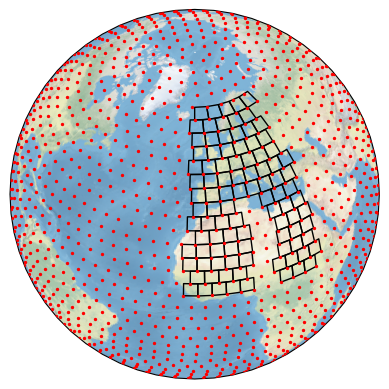

In [5]:
proj = ccrs.Orthographic(-10, 40)

fig, ax = plt.subplots(subplot_kw={"projection": proj})

ax.set_global()
ax.stock_img()
mycells_aoi.plot(ax=ax, edgecolor="black", facecolor="None", transform=ccrs.Geodetic())
mypoints.plot(ax=ax, markersize=2, color="red", transform=ccrs.PlateCarree(), zorder=3)

<GeoAxes: >

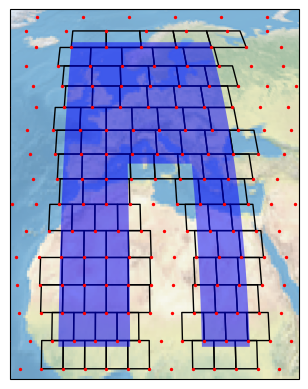

In [6]:
proj = ccrs.EqualEarth()
proj.threshold = proj.threshold / 100.0

fig, ax = plt.subplots(subplot_kw={"projection": proj})

ax.set_extent([-20, 40, 5, 75], crs=ccrs.PlateCarree())
ax.stock_img()
mycells_aoi.plot(
    ax=ax, edgecolor="black", facecolor="None", transform=ccrs.PlateCarree()
)
gpd.GeoSeries(aoi, crs=4326).plot(
    ax=ax, color="blue", alpha=0.5, transform=ccrs.PlateCarree()
)
mypoints.plot(ax=ax, markersize=2, color="red", transform=ccrs.PlateCarree(), zorder=3)

In [7]:
sgi = gpd.read_file(ROOT_DIR / "data/raw/inventory_sgi2016_r2020/SGI_2016_glaciers.shp")

WGS84 = "EPSG:4326"
CEA = "+proj=cea"

# Clean file
sgi = sgi.drop(columns="pk_glacier")
sgi.gid = sgi.gid.astype(int)
sgi = sgi.set_index("gid", verify_integrity=True).sort_index().to_crs(WGS84)

# Get a single shape of the union
sgi_union = sgi.union_all()

In [8]:
grid = MajorTOMGrid(dist=10_000)
cells = grid.get_cells(aoi=sgi_union, buffer_ratio=0.05)
cells.head()

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
4390552,1452,1512,7.086614,45.808383,0.128848,u0jh970m,EPSG:32632,"POLYGON ((7.08017 45.80389, 7.2219 45.80389, 7..."
4390553,1453,1512,7.215462,45.808383,0.128848,u0jhs5nj,EPSG:32632,"POLYGON ((7.20902 45.80389, 7.35075 45.80389, ..."
4390554,1454,1512,7.344309,45.808383,0.128848,u0jhx55v,EPSG:32632,"POLYGON ((7.33787 45.80389, 7.4796 45.80389, 7..."
4393342,1448,1513,6.905701,45.898204,0.129079,u0hvj5s8,EPSG:32632,"POLYGON ((6.89925 45.89371, 7.04123 45.89371, ..."
4393343,1449,1513,7.034779,45.898204,0.129079,u0jj05d8,EPSG:32632,"POLYGON ((7.02833 45.89371, 7.17031 45.89371, ..."


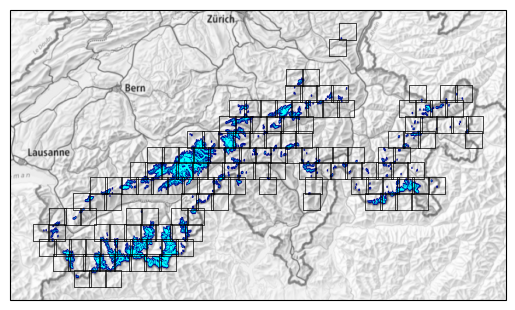

In [9]:
# Add buffer to SGI for visualization
sgi_buffered = sgi.to_crs(CEA).simplify(100).buffer(500).to_crs(WGS84)

proj = ccrs.UTM(32)
fig, ax = plt.subplots(subplot_kw={"projection": proj})

sgi_buffered.plot(ax=ax, color="darkblue")
sgi.plot(ax=ax, color="cyan")
cells.plot(ax=ax, edgecolor="black", linewidth=0.5, color="None")

cx.add_basemap(
    ax,
    crs=sgi.crs,
    # source=cx.providers.OpenStreetMap.Mapnik,
    source=cx.providers.SwissFederalGeoportal.NationalMapGrey,
    attribution=False,
)
